# ACM Abstract Topic Classifier
MiniLM embedding + LogisticRegression (One‑vs‑Rest)

In [2]:
# --- Imports & environment ---
import os, pickle, joblib, subprocess
from pathlib import Path

import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from sentence_transformers import SentenceTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import LinearSVC
from sklearn.metrics import (precision_score, recall_score, multilabel_confusion_matrix,
                             f1_score, accuracy_score, hamming_loss)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on:", device)

nltk.download('stopwords')
stop_words = stopwords.words('english')

/home/konstanty/Projects/UW/UWvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/konstanty/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# --- Helper Functions ---
def flatten_if_single(x):
    """If x is a list of length 1, return its first element."""
    if isinstance(x, list) and len(x) == 1:
        return x[0]
    return x

def load_or_train_mlb(train_labels, path=Path('models/mlb_model.pkl'), all_labels=None):
    if path.exists():
        print('✓ MLB loaded')
        return joblib.load(path)
    print('… training MultiLabelBinarizer')
    if all_labels is None:
        all_labels = sorted({lbl for sub in train_labels for lbl in sub})
    mlb = MultiLabelBinarizer(classes=all_labels)
    mlb.fit(train_labels)
    joblib.dump(mlb, path)
    return mlb

def notify():
    try:
        subprocess.run(['play', '-nq', '-t', 'alsa', 'synth', '0.3', 'sine', '1000'])
    except FileNotFoundError:
        pass


In [4]:
# --- Load data ---
notebook_dir = os.getcwd()
test_path  = os.path.join(notebook_dir, 'data', 'DM2023_test_docs.tsv')
train_path = os.path.join(notebook_dir, 'data', 'DM2023_training_docs_and_labels.tsv')

test = pd.read_csv(test_path,  sep='\t', encoding='latin1',
                   header=None, names=['Textfile','Text','Topics'])

train_full = pd.read_csv(train_path, sep='\t', encoding='latin1',
                         header=None, names=['Textfile','Text','Topics'])

# Split topics string into list
train_full['Topics'] = (train_full['Topics']
                        .apply(flatten_if_single)
                        .str.split(r'\s*,\s*'))


In [5]:
# --- Train / Validation split ---
split = int(train_full.shape[0] * 0.8)
val   = train_full.iloc[split:].reset_index(drop=True)
train = train_full.iloc[:split].reset_index(drop=True)
print('Train:', train.shape, ' Val:', val.shape)

Train: (80000, 3)  Val: (20000, 3)


In [6]:
# --- SentenceTransformer Embeddings ---
bert_path = Path('models/embed/minilm_model.pkl')  # change filename if you switch model

if bert_path.exists():
    print('\n\t model loaded')
    model = joblib.load(bert_path)
else:
    print('\n\t… loading MiniLM')
    model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
    joblib.dump(model, bert_path)

embed_paths = [Path('models/embed/X_train_embed.npy'),
               Path('models/embed/X_val_embed.npy'),
               Path('models/embed/X_test_embed.npy')]

if all(p.exists() for p in embed_paths):
    X_train_embed = np.load(embed_paths[0])
    X_val_embed   = np.load(embed_paths[1])
    X_test_embed  = np.load(embed_paths[2])
else:
    X_train_embed = model.encode(train['Text'].tolist(), batch_size=32, show_progress_bar=True)
    X_val_embed   = model.encode(val['Text'].tolist(),   batch_size=32, show_progress_bar=True)
    X_test_embed  = model.encode(test['Text'].tolist(),  batch_size=32, show_progress_bar=True)

    np.save(embed_paths[0], X_train_embed)
    np.save(embed_paths[1], X_val_embed)
    np.save(embed_paths[2], X_test_embed)



# --- Label binarization ---
all_topics = sorted({lbl for sub in train_full['Topics'] for lbl in sub})
mlb = load_or_train_mlb(train['Topics'], all_labels=all_topics)

y_train = mlb.transform(train['Topics'])
y_val   = mlb.transform(val['Topics'])


	 model loaded
✓ MLB loaded


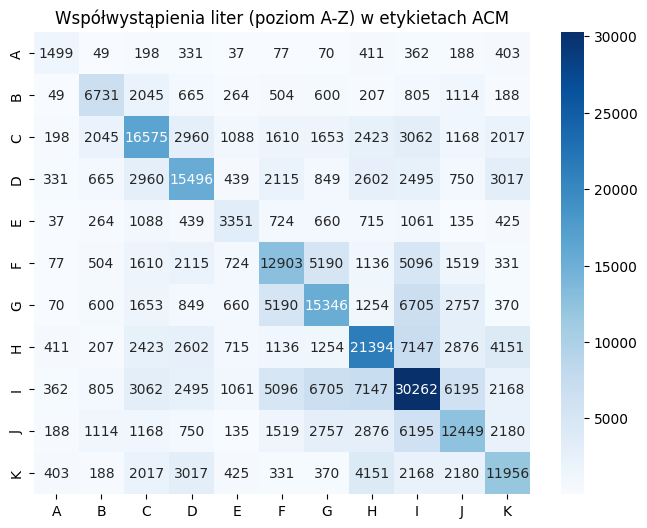

In [7]:
# --- Plots ---

letters = sorted({cls[0] for cls in mlb.classes_})   # np. ['A','C','D','E',...]
L = len(letters)
letter2idx = {ch:i for i,ch in enumerate(letters)}

# --- 2. zlicz współwystąpienia liter (dokument × dokument) ---
co_mat = np.zeros((L, L), dtype=int)

for row in y_train:                       
    doc_letters = {mlb.classes_[i][0] for i in np.where(row)[0]}
    for a in doc_letters:
        for b in doc_letters:
            co_mat[letter2idx[a], letter2idx[b]] += 1


plt.figure(figsize=(8,6))
sns.heatmap(co_mat, xticklabels=letters, yticklabels=letters,
            cmap="Blues", annot=True, fmt="d")
plt.title("Współwystąpienia liter (poziom A-Z) w etykietach ACM")
plt.savefig("output/coexistence.png")
plt.show()

In [8]:
# --- Train or load classifier ---
clf_path = Path('models/embed/classifier.pkl')

if clf_path.exists():
    print('\n\tFound classifier model!')
    with open(clf_path, 'rb') as f:
        clf = joblib.load(f)
else:
    print('\n\tWe need to train classifier first...')
   
    base = LinearSVC(C=1.0, dual=False)
    clf = OneVsRestClassifier(base, n_jobs=-1)
    clf.fit(X_train_embed, y_train)
    joblib.dump(clf, clf_path)
    notify()



	Found classifier model!


In [9]:
# --- Validation ---

scores = clf.decision_function(X_val_embed)
y_pred_bin = np.zeros_like(scores, dtype=int)

for i, row in enumerate(scores):
    top_idx = row.argmax()
    y_pred_bin[i, top_idx] = 1                 # zawsze co najmniej 1 etykieta
    y_pred_bin[i, row > -0.3] = 1              # + inne, które przekroczą próg


val['PredictedTopics'] = mlb.inverse_transform(y_pred_bin)

y_val_true_bin = mlb.transform(val['Topics'])

print('\n\n=== SAMPLE-BASED METRICS ===')
print('Precision (samples):', precision_score(y_val_true_bin, y_pred_bin,
                                             average='samples', zero_division=0))
print('Recall    (samples):', recall_score(y_val_true_bin, y_pred_bin, average='samples'))
print('F1        (samples):', f1_score(y_val_true_bin, y_pred_bin,
                                       average='samples', zero_division=0))
print('Subset accuracy   :', accuracy_score(y_val_true_bin, y_pred_bin))
print('Hamming loss      :', hamming_loss(y_val_true_bin, y_pred_bin))





=== SAMPLE-BASED METRICS ===
Precision (samples): 0.5559144047619047
Recall    (samples): 0.3821262518037518
F1        (samples): 0.4141946558996559
Subset accuracy   : 0.06345
Hamming loss      : 0.0073371508379888265


/home/konstanty/Projects/UW/UWvenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


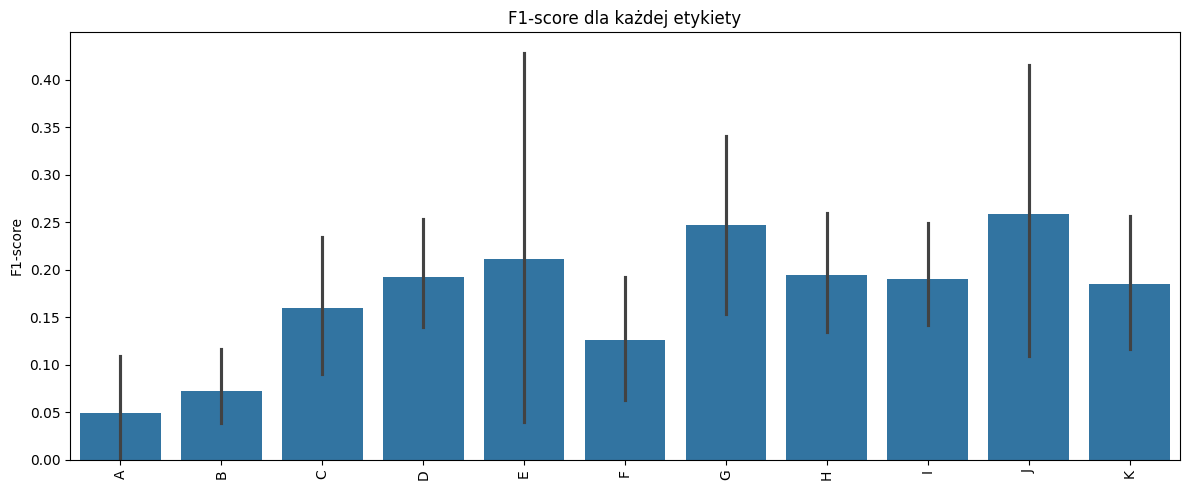

In [10]:
f1s = f1_score(y_val_true_bin, y_pred_bin, average=None)
labels = mlb.classes_
labels = [label[0] for label in labels]

plt.figure(figsize=(12,5))
sns.barplot(x=labels, y=f1s)
plt.xticks(rotation=90)
plt.ylabel("F1-score")
plt.title("F1-score dla każdej etykiety")
plt.tight_layout()
plt.savefig("output/f1_per_class.png")

In [11]:
# --- Predict on test & save submission ---

scores = clf.decision_function(X_test_embed)
y_test_bin = np.zeros_like(scores, dtype=int)

for i, row in enumerate(scores):
    top_idx = row.argmax()
    y_test_bin[i, top_idx] = 1                 # zawsze co najmniej 1 etykieta
    y_test_bin[i, row > -0.3] = 1              # + inne, które przekroczą próg



label_lists = mlb.inverse_transform(y_test_bin)

submission = test
submission["Topics"] = [",".join(labels) for labels in label_lists]

with open("output/submission.txt", "w", encoding="utf-8") as f:
    for labels in label_lists:
        f.write(",".join(labels) + "\n")